# Sampling minimal pathways in *Escherichia coli* central carbon metabolism

This notebook performs the analysis of *E. coli* central carbon metabolism presented in our preprint:

O. Øyås, A. Theorell, and J. Stelling. "Scalable enumeration and sampling of minimal metabolic pathways for organims and communities". *bioRxiv* (2024).

In [1]:
import cobra
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import re

from collections import defaultdict
from matplotlib import rcParams
from os import listdir
from os.path import join
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression

from mptool import *

%matplotlib inline
sns.set_theme(context='paper', style='ticks', font_scale=1.5)

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['mathtext.it'] = 'Arial:italic'
rcParams['mathtext.bf'] = 'Arial:bold'

results_dir = 'results'

## Load single and multiple gene knockout data

Data from Baba et al. (2006) https://doi.org/10.1038/msb4100050 and Nakahigashi et al. (2009) https://doi.org/10.1038/msb.2009.65.

In [2]:
# Load single KO data from the Keio collection
df = pd.read_excel('data/msb4100050-sup-0005.xls', header=[3], usecols=[0, 1, 2, 8, 16, 17, 18, 19, 23],
                   names=['eck', 'gene', 'jw', 'b', 'percent', 'lb22', 'mops24', 'mops48', 'score'])

# Replace text NaNs
df = df.replace(['N.A.', 'N.T.', 'NT'], np.nan)

# Classify essential genes using Keio growth data
df['essential_keio'] = df.percent == 0

# Classify essential genes using aggregated essentiality scores
# gene_df['essential_score'] = gene_df.score > 0
# # gene_df['essential_score'] = gene_df.score > 1
# gene_df.loc[(gene_df.score >= -1) & (gene_df.score <= 0), 'essential_score'] = np.nan

# Set zero growth for essential genes (replacing NaNs)
df.loc[df.essential_keio, ['lb22', 'mops24', 'mops48']] = 0.0

gene_df = df

gene_df

/var/folders/0z/0wtrv7xn7yq6df17wtbwn69c0000gn/T/ipykernel_24052/1750577806.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(['N.A.', 'N.T.', 'NT'], np.nan)


eck  gene      jw      b  percent   lb22  mops24  mops48  score  \
0     ECK0001  thrL  JW4367  b0001     87.5  0.848   0.355   0.542   -2.5   
1     ECK0002  thrA  JW0001  b0002     75.0  0.793   0.023   0.040   -3.0   
2     ECK0003  thrB  JW0002  b0003     75.0  0.682   0.004   0.010   -2.5   
3     ECK0004  thrC  JW0003  b0004     62.5  0.625   0.000   0.000   -3.0   
4     ECK0005  yaaX  JW0004  b0005    100.0  0.836   0.382   0.469   -2.0   
...       ...   ...     ...    ...      ...    ...     ...     ...    ...   
4373  ECK4391  creC  JW4362  b4399     75.0  0.743   0.249   0.176   -4.0   
4374  ECK4392  creD  JW4363  b4400    100.0  0.803   0.334   0.328   -4.0   
4375  ECK4393  arcA  JW4364  b4401     87.5  0.741   0.395   0.505   -2.5   
4376  ECK4394  yjjY  JW4365  b4402    100.0  0.781   0.817   0.457   -1.5   
4377  ECK4395  yjtD  JW4366  b4403     87.5  0.743   0.339   0.479   -3.0   

      essential_keio  
0              False  
1              False  
2              False  
3              False  
4              False  
...              ...  
4373           False  
4374           False  
4375           False  
4376           False  
4377           False  

[4378 rows x 10 columns]

In [3]:
# Load multiple KO data
df = pd.read_excel('data/msb200965-sup-0003.xls', header=2, usecols=np.arange(18))

# Clean up 
df = df[:3328]
df.columns = [c.replace('W_24h', 'w_24h_rel').lower().split('(')[0].strip().replace(' ', '_').replace('-', '_') for c in df.columns]
df['gene_1'] = df['1st_deletion']
df['gene_2'] = df['2nd_deletion']
df = df.drop(['1st_deletion', '2nd_deletion'], axis=1)

# Replace text NaNs
df = df.replace(['N.A.', 'N.T.', 'NT'], np.nan)

for c in ['w_pre', 'w_24h', 'w_48h', 'w_24h_rel', 'mu', 'mu_2', 'w_mu', 'w_mu_2', 'rgie', 'rgis', 'rgis_2']:
    df[c] = df[c].astype(float)

df = df[(df.carbon_source == 'Glucose')]
df = df[~(df.w_24h.isna())]

s = {'control', 'rrnH(Control)'}
# s = {'rrnH(Control)'}
df = df[(~df.gene_1.isin(s)) & (~df.gene_2.isin(s))]

pair_df = df.reset_index()

pair_df

/var/folders/0z/0wtrv7xn7yq6df17wtbwn69c0000gn/T/ipykernel_24052/2741557502.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(['N.A.', 'N.T.', 'NT'], np.nan)


index  case_no  strain_no  medium_no carbon_source control  w_pre  \
0      117      118       10.0        1.0       Glucose     NaN    NaN   
1      130      131       11.0        1.0       Glucose     NaN    NaN   
2      143      144       12.0        1.0       Glucose     NaN    NaN   
3      156      157       13.0        1.0       Glucose     NaN    NaN   
4      169      170       14.0        1.0       Glucose     NaN    NaN   
..     ...      ...        ...        ...           ...     ...    ...   
200   3263     3264      252.0        1.0       Glucose     NaN    NaN   
201   3276     3277      253.0        1.0       Glucose     NaN    NaN   
202   3289     3290      254.0        1.0       Glucose     NaN    NaN   
203   3302     3303      255.0        1.0       Glucose     NaN    NaN   
204   3315     3316      256.0        1.0       Glucose     NaN    NaN   

      w_24h   w_48h  w_24h_rel     mu   mu_2      w_mu    w_mu_2      rgie  \
0    0.0827  0.5218   0.218610  0.177  0.135  0.225765  0.172194 -0.800386   
1   -0.0007  0.0139  -0.001850  0.177  0.135  0.225765  0.172194 -1.002007   
2   -0.0012 -0.0008  -0.003172  0.177  0.135  0.225765  0.172194 -1.003429   
3    0.0025  0.0573   0.006609  0.177  0.135  0.225765  0.172194 -0.992733   
4    0.0019  0.0087   0.005022  0.177  0.135  0.225765  0.172194 -0.992523   
..      ...     ...        ...    ...    ...       ...       ...       ...   
200  0.3273  0.3463   0.865186  0.783  0.783  0.998724  0.998724 -0.064857   
201  0.3195  0.3287   0.844568  0.783  0.783  0.998724  0.998724 -0.071221   
202  0.2380  0.2175   0.629130  0.499  0.499  0.636480  0.636480 -0.063361   
203  0.3323  0.3441   0.878403  0.702  0.702  0.895408  0.895408 -0.070229   
204  0.3597  0.3263   0.950833  0.776  0.776  0.989796  0.989796 -0.013710   

         rgis    rgis_2 gene_1    gene_2  
0    0.000000  0.000000   aceE       pgi  
1    0.000000  0.000000   aceE       zwf  
2    0.000000  0.000000   aceE      aceA  
3    0.000000  0.000000   aceE        ME  
4    0.000000  0.000000   aceE  ppc_pckA  
..        ...       ...    ...       ...  
200  0.000000  0.000000    zwf      aceA  
201  0.000000  0.000000    zwf        ME  
202  0.000000  0.000000    zwf  ppc_pckA  
203 -0.103448 -0.103448    zwf       Tal  
204  0.000000  0.000000    zwf       Pyk  

[205 rows x 19 columns]

In [4]:
# Map gene names and b numbers
df = gene_df
gene_map = dict(zip(df.b, df.gene))
gene_map.update(dict(zip(df.gene, df.b)))
gene_map

{'b0001': 'thrL',
 'b0002': 'thrA',
 'b0003': 'thrB',
 'b0004': 'thrC',
 'b0005': 'yaaX',
 'b0006': 'yaaA',
 'b0007': 'yaaJ',
 'b0008': 'talB',
 'b0009': 'mog',
 'b0010': 'yaaH',
 'b0011': 'yaaW',
 'b0012': 'htgA',
 'b0013': 'yaaI',
 'b0014': 'dnaK',
 'b0015': 'dnaJ',
 'b0016': 'insL',
 'b4412': 'hokC',
 'b0019': 'nhaA',
 'b0020': 'nhaR',
 'b0021': 'insB',
 'b0022': 'insA',
 'b0023': 'rpsT',
 'b0024': 'yaaY',
 'b0025': 'ribF',
 'b0026': 'ileS',
 'b0027': 'lspA',
 'b0028': 'fkpB',
 'b0029': 'ispH',
 'b0030': 'rihC',
 'b0031': 'dapB',
 'b0032': 'carA',
 'b0033': 'carB',
 'none': 'none',
 'b0034': 'caiF',
 'b0035': 'caiE',
 'b0036': 'caiD',
 'b0037': 'caiC',
 'b0038': 'caiB',
 'b0039': 'caiA',
 'b0040': 'caiT',
 'b0041': 'fixA',
 'b0042': 'fixB',
 'b0043': 'fixC',
 'b0044': 'fixX',
 'b0045': 'yaaU',
 'b0046': 'kefF',
 'b0047': 'kefC',
 'b0048': 'folA',
 'b0049': 'apaH',
 'b0050': 'apaG',
 'b0051': 'ksgA',
 'b0052': 'pdxA',
 'b0053': 'surA',
 'b0054': 'imp',
 'b0055': 'djlA',
 'b0056': 'ya

In [5]:
s0 = set(gene_df.gene)
s1 = set(pair_df.gene_1)
s2 = set(pair_df.gene_2)

len(s0), len(s1), len(s0 & s1), len(s2), len(s0 & s2)

(4213, 31, 26, 7, 3)

In [6]:
s1 - s0, s2 - s0

({'gpmB', 'icdA', 'lpdA', 'pckA', 'ppsA'}, {'ME', 'Pyk', 'Tal', 'ppc_pckA'})

In [7]:
ko_map = {x: [x] for x in s1 | s2}
ko_map.update({
    'icdA': ['icd'],
    'lpdA': ['lpd'],
    'gpmB': ['gpmA', 'gpmI'],
    'ME': ['sfcA', 'maeB'],
    'pckA': ['pck'],
    'ppc_pckA': ['ppc', 'pck'],
    'ppsA': ['pps'],
    'Pyk': ['pykA', 'pykF'],
    'Tal': ['talA', 'talB']
})
ko_map

{'gpmB': ['gpmA', 'gpmI'],
 'pykF': ['pykF'],
 'aceE': ['aceE'],
 'talB': ['talB'],
 'rpiA': ['rpiA'],
 'pckA': ['pck'],
 'fbaB': ['fbaB'],
 'tktB': ['tktB'],
 'pfkA': ['pfkA'],
 'ppc': ['ppc'],
 'glk': ['glk'],
 'rpiB': ['rpiB'],
 'sfcA': ['sfcA'],
 'pykA': ['pykA'],
 'lpdA': ['lpd'],
 'gltA': ['gltA'],
 'gpmI': ['gpmI'],
 'aceA': ['aceA'],
 'gnd': ['gnd'],
 'pfkB': ['pfkB'],
 'gpmA': ['gpmA'],
 'tktA': ['tktA'],
 'rpe': ['rpe'],
 'Pyk': ['pykA', 'pykF'],
 'maeB': ['maeB'],
 'pgi': ['pgi'],
 'ppsA': ['pps'],
 'zwf': ['zwf'],
 'ME': ['sfcA', 'maeB'],
 'Tal': ['talA', 'talB'],
 'aceF': ['aceF'],
 'tpiA': ['tpiA'],
 'icdA': ['icd'],
 'ppc_pckA': ['ppc', 'pck'],
 'talA': ['talA'],
 'fbp': ['fbp']}

In [8]:
# Get sets of KO pairs

ko_pairs = []

for i, row in pair_df.iterrows():
    ko_pair = (set(ko_map[row.gene_1]), set(ko_map[row.gene_2]))
    # ko_pair = [set(c[row.gene_1])]
    try:
        ko_pair = frozenset(frozenset(gene_map[x] for x in ko) for ko in ko_pair)
    except KeyError:
        print(ko_pair)
        continue
    ko_pairs.append(ko_pair)

len(ko_pairs)

205

## Load model and subnetwork

In [9]:
# Load model
model = cobra.io.read_sbml_model('models/iJO1366.xml')
model

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-27


<Model iJO1366 at 0x33d32f4a0>

In [11]:
# Load reactions in subnetwork (central carbon metabolism)
ccm = set()
with open('data/iJO1366_ccm.txt', 'r') as f:
    for line in f:
        ccm.add(line.strip())

In [12]:
# Get genes in subnetwork
ccm_genes = set()
for x in ccm:
    r = model.reactions.get_by_id(x)
    ccm_genes |= set(g.id for g in r.genes)
ccm_genes.remove('s0001')

## Constrain model

In [14]:
# Choose medium (minimal glucose or glucose and amino acids)
medium = 'min_glc'
# medium = 'glc_aa'
medium

'min_glc'

In [15]:
# # Get growth and ATP maintenance reactions
bm = model.reactions.BIOMASS_Ec_iJO1366_core_53p95M
atpm = model.reactions.ATPM

# Set growth and ATP maintenance requirements
bm.bounds = 0.1, 1000
# atpm.bounds = 0, 0

# Turn off alternative biomass reaction
model.reactions.BIOMASS_Ec_iJO1366_WT_53p95M.bounds = 0, 0

In [16]:
# Check the default minimal glucose medium
for r in model.boundary:
    if r.lower_bound:
        print(r, r.bounds)

EX_co2_e: co2_e <=>  (-1000.0, 1000.0)
EX_cobalt2_e: cobalt2_e <=>  (-1000.0, 1000.0)
EX_glc__D_e: glc__D_e <=>  (-10.0, 1000.0)
EX_h_e: h_e <=>  (-1000.0, 1000.0)
EX_h2o_e: h2o_e <=>  (-1000.0, 1000.0)
EX_k_e: k_e <=>  (-1000.0, 1000.0)
EX_cu2_e: cu2_e <=>  (-1000.0, 1000.0)
EX_mg2_e: mg2_e <=>  (-1000.0, 1000.0)
EX_mn2_e: mn2_e <=>  (-1000.0, 1000.0)
EX_mobd_e: mobd_e <=>  (-1000.0, 1000.0)
EX_na1_e: na1_e <=>  (-1000.0, 1000.0)
EX_nh4_e: nh4_e <=>  (-1000.0, 1000.0)
EX_ca2_e: ca2_e <=>  (-1000.0, 1000.0)
EX_cbl1_e: cbl1_e <=>  (-0.01, 1000.0)
EX_ni2_e: ni2_e <=>  (-1000.0, 1000.0)
EX_o2_e: o2_e <=>  (-1000.0, 1000.0)
EX_cl_e: cl_e <=>  (-1000.0, 1000.0)
EX_pi_e: pi_e <=>  (-1000.0, 1000.0)
EX_zn2_e: zn2_e <=>  (-1000.0, 1000.0)
EX_sel_e: sel_e <=>  (-1000.0, 1000.0)
EX_slnt_e: slnt_e <=>  (-1000.0, 1000.0)
EX_so4_e: so4_e <=>  (-1000.0, 1000.0)
EX_tungs_e: tungs_e <=>  (-1000.0, 1000.0)
EX_fe2_e: fe2_e <=>  (-1000.0, 1000.0)
EX_fe3_e: fe3_e <=>  (-1000.0, 1000.0)


In [17]:
# Add constraints from Nakahigashi et al. (2009)

bounds = {
    'F6PA': (0, 0),
    'G3PD2': (-0.2, None),
    'EDD': (0, 0),
    'GLCDpp': (0, 0),
    'MGSA': (0, 0),
    'DRPA': (0, 0),
    'ASPK': (None, 0.5),
    'ACALD': (None, 0.1),
    'POX': (None, 0.1),
    'ALDD2x': (None, 0.1),
    'CITL': (None, 0.1),
    'GLYAT': (-0.1, None),
    'PGI': (-0.1, None),
    'THRD': (0, 0),
    'THRA': (0, 0),
    'OAADC': (0, 0),
    'MCITS': (0, 0),
    'GLXCL': (0, 0),
    'EX_kdo2lipid4_e': (0, 0),
    'EX_lipa_cold_e': (0, 0),
    'EX_lipa_e': (0, 0),
    'EX_enlipa_e': (0, 0),
}

# Apply updates to the model
for x, (lb, ub) in bounds.items():
    r = model.reactions.get_by_id(x)
    if lb is not None:
        r.lower_bound = lb
    if ub is not None:
        r.upper_bound = ub

model.optimize()

<Solution 0.468 at 0x33d946480>

In [18]:
if medium == 'glc_aa':
    # Add CAS amino acids from Nakahigashi et al. (2009) to medium

    aas = {
        'EX_ala__L_e': -0.21,
        'EX_arg__L_e': -0.08,
        'EX_asp__L_e': -0.22,
        'EX_cys__L_e': 0.0,
        'EX_glu__L_e': -0.62,
        'EX_gly_e': -0.12,
        'EX_his__L_e': -0.07,
        'EX_ile__L_e': -0.18,
        'EX_leu__L_e': -0.22,
        'EX_lys__L_e': -0.23,
        'EX_met__L_e': -0.05,
        'EX_phe__L_e': -0.12,
        'EX_pro__L_e': -0.41,
        'EX_ser__L_e': -0.11,
        'EX_thr__L_e': -0.08,
        'EX_trp__L_e': 0.0,
        'EX_tyr__L_e': -0.01,
        'EX_val__L_e': -0.28
    }

    for x, lb in aas.items():
        model.reactions.get_by_id(x).lower_bound = lb
        # model.reactions.get_by_id(x).lower_bound = 0
        # if lb:
        #     model.reactions.get_by_id(x).lower_bound = -10

model.optimize()

<Solution 0.468 at 0x33d946960>

## Load or sample MPs

In [19]:
if medium == 'min_glc':
    # Load or sample MPs from subnetwork with minimal glucose medium
    try:
        samples_min = load_sets('data/iJO1366_20240315_0903239975958_random_incomplete_mps.csv')
    except FileNotFoundError:
        n = 1e5
        mps, _, _ = find_mps(model, subset=ccm, method='iterative', tol=1e-9,
                            graph=False, random=True, bounds={}, tighten=True,
                            inf=1000, threads=0, max_mps=n, max_t=None,
                            verbose=True, export=True)
        samples_min = mps

    # Load or sample MPs from full network with minimal glucose medium
    try:
        samples_min_full = load_sets('data/iJO1366_20240314_2323560160482_random_incomplete_mps.csv')
    except FileNotFoundError:
        n = 1e4
        mps, _, _ = find_mps(model, subset=set(), method='iterative', tol=1e-9,
                            graph=False, random=True, bounds={}, tighten=True,
                            inf=1000, threads=0, max_mps=n, max_t=None,
                            verbose=True, export=True)
        samples_min_full = mps

    # Choose samples
    samples = samples_min
    # samples = samples_min_full

    print(len(samples))

100000


In [20]:
if medium == 'glc_aa':
    # Load or sample MPs from subnetwork with glucose and amino acid medium
    try:
        samples_aa = load_sets('data/iJO1366_20240317_072808221041_random_incomplete_mps.csv')
    except FileNotFoundError:
        n = 1e5
        mps, _, _ = find_mps(model, subset=ccm, method='iterative', tol=1e-9,
                            graph=False, random=True, bounds={}, tighten=True,
                            inf=1000, threads=0, max_mps=n, max_t=None,
                            verbose=True, export=True)
        samples_aa = mps
    
    # Load or sample MPs from full network with glucose and amino acid medium
    try:
        samples_aa_full = load_sets('data/iJO1366_20240317_145938123126_random_incomplete_mps.csv')
    except FileNotFoundError:
        n = 1e4
        mps, _, _ = find_mps(model, subset=set(), method='iterative', tol=1e-9,
                            graph=False, random=True, bounds={}, tighten=True,
                            inf=1000, threads=0, max_mps=n, max_t=None, verbose=True,
                            export=True)
        samples_aa_full = mps
    
    # Choose samples
    samples = samples_aa

    print(len(samples))

In [21]:
# Build sample data frame
sample_df = pd.DataFrame([{x: 1 for x in s } for s in samples]).fillna(0).astype(int)
sample_df

ACONTa  GAPD  PPA  ACONTb  PFL  ATPS4rpp  HCO3E  HEX1  TPI  PGL  ...  \
0           1     1    1       1    1         1      1     1    1    1  ...   
1           1     1    1       1    0         1      1     1    0    1  ...   
2           1     1    1       1    0         1      1     0    1    0  ...   
3           1     1    0       1    0         1      1     0    1    0  ...   
4           1     1    0       1    0         1      1     0    1    0  ...   
...       ...   ...  ...     ...  ...       ...    ...   ...  ...  ...  ...   
99995       1     1    0       1    0         0      1     0    1    0  ...   
99996       1     1    1       1    0         1      1     0    1    1  ...   
99997       1     1    1       1    0         1      1     0    1    0  ...   
99998       1     1    0       1    0         1      1     1    1    1  ...   
99999       1     1    0       1    1         1      1     0    1    0  ...   

       G3PD7  G3PT  G3PD5  L_LACD2  ACALDtpp_rev  12PPDRtpp_rev  LCARR  \
0          0     0      0        0             0              0      0   
1          0     0      0        0             0              0      0   
2          0     0      0        0             0              0      0   
3          0     0      0        0             0              0      0   
4          0     0      0        0             0              0      0   
...      ...   ...    ...      ...           ...            ...    ...   
99995      0     0      0        0             0              0      0   
99996      0     0      0        0             0              0      0   
99997      0     0      0        0             0              0      0   
99998      0     0      0        0             0              0      0   
99999      0     0      0        0             0              0      0   

       LALDO2x  PGM  ENO_rev  
0            0    0        0  
1            0    0        0  
2            0    0        0  
3            0    0        0  
4            0    0        0  
...        ...  ...      ...  
99995        0    0        0  
99996        0    0        0  
99997        0    0        0  
99998        0    0        0  
99999        0    0        0  

[100000 rows x 121 columns]

In [22]:
# Sum reversible reactions
df = sample_df
drop = []
for c in df.columns:
    if c.endswith('_rev'):
        try:
            df[c[:-4]] += df[c]
        except KeyError:
            df[c[:-4]] = df[c]
        drop.append(c)
df = df.drop(drop, axis=1)
sample_df = df
sample_df.max().max() == 1

True

## Analyze reaction frequencies

In [23]:
# Compute reaction frequencies
reac_frac = defaultdict(float)
reac_frac.update(dict(sample_df.sum() / len(sample_df)))
reac_frac

defaultdict(float,
            {'ACONTa': 1.0,
             'GAPD': 1.0,
             'PPA': 0.47168,
             'ACONTb': 1.0,
             'PFL': 0.33008,
             'ATPS4rpp': 0.68255,
             'HCO3E': 1.0,
             'HEX1': 0.28274,
             'TPI': 0.93043,
             'PGL': 0.46446,
             'CS': 1.0,
             'NADH16pp': 0.20389,
             'PPC': 0.61674,
             'FBA3': 0.45472,
             'SUCCt3pp': 0.23699,
             'FORtppi': 0.46016,
             'ICDHyr': 1.0,
             'GND': 0.46446,
             'ATPM': 1.0,
             'G6PDH2r': 0.46446,
             'CYTBDpp': 0.32483,
             'PFK_3': 0.45472,
             'PPS': 0.35931,
             'TKT1': 0.47347,
             'CYTBO3_4pp': 0.42873,
             'FRD3': 0.07438,
             'SUCDi': 0.24367,
             'NADH9': 0.01312,
             'RPE': 0.89353,
             'TKT2': 0.85064,
             'CITt7pp': 0.12393,
             'CITt3pp': 0.12962,
             'EN

In [24]:
# Export reaction frequencies for Escher
with open('data/reac_frac_' + medium + '.csv', 'w') as f:
    for x in sorted(reac_frac):
        f.write(','.join([x, str(reac_frac[x])]) + '\n')

In [25]:
if medium == 'min_glc':
    # Write reaction frequency supplementary table
    d = defaultdict(list)
    for x in sorted(ccm):
        r = model.reactions.get_by_id(x)
        d['id'].append(r.id)
        d['name'].append(r.name)
        # d['subsystem'].append(r.subsystem)
        try:
            d['frequency_mp'].append(reac_frac[x])
        except KeyError:
            d['frequency_mp'].append(0)
        # d['importance_fba'].append(1 - rd_df.loc[x].iloc[0] / wt_growth)
    df = pd.DataFrame(d)
    # df.loc[df.importance_fba < 1e-6, 'importance_fba'] = 0
    df.to_excel(join(results_dir, 'reaction_frequency.xlsx'), index=False)

In [130]:
# Check convergence of reaction frequencies in subsamples by bootstrapping

d = defaultdict(list)

# Get essential reactions
e = [k for k, v in reac_frac.items() if v == 1]

# Choose subsample counts
counts = range(100)

# Choose 100 or 1000 integer subsample sizes (filters out non-integers)
sizes = np.unique(np.logspace(0, np.log10(len(samples)), 114).astype(int))
# sizes = np.unique(np.logspace(0, np.log10(len(samples)), 1509).astype(int))

for m in counts:
    print(m)
    for n in sizes:
        # i = random.sample(range(len(samples)), int(n))
        i = random.choices(range(len(samples)), k=int(n))
        s = sample_df.loc[i].sum(0) / n

        # Sanity check for essential reactions
        if not (s[e] == 1).all():
            print(m, n)
            print(i)
            print(s)
            break

        s_rel = s / (sample_df.sum(0) / len(sample_df))

        d['reaction'].extend(s.index)
        d['frac'].extend(s.values)
        d['frac_rel'].extend(s_rel.values)
        d['m'].extend([m] * len(s))
        d['n'].extend([n] * len(s))
        # break

bs_df = pd.DataFrame(d)

# Compute log values
bs_df['log_n'] = np.log10(bs_df.n)
bs_df['log_frac'] = np.log10(bs_df.frac)
bs_df['log_frac_rel'] = np.log10(bs_df.frac_rel)

bs_df

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


/opt/homebrew/Caskroom/miniconda/base/envs/mptool/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/mptool/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


reaction     frac  frac_rel   m       n  log_n  log_frac  \
0               FUM  1.00000  1.477541   0       1    0.0  0.000000   
1        CYTBO3_4pp  0.00000  0.000000   0       1    0.0      -inf   
2             SUCDi  0.00000  0.000000   0       1    0.0      -inf   
3              FBA3  1.00000  2.468648   0       1    0.0  0.000000   
4             AKGDH  0.00000  0.000000   0       1    0.0      -inf   
...             ...      ...       ...  ..     ...    ...       ...   
1079995    ACALDtpp  0.00093  1.010870  99  100000    5.0 -3.031517   
1079996    ETOHtrpp  0.00124  0.976378  99  100000    5.0 -2.906578   
1079997      ALCD2x  0.00124  0.976378  99  100000    5.0 -2.906578   
1079998  L_LACt2rpp  0.00035  0.921053  99  100000    5.0 -3.455932   
1079999   12PPDRtpp  0.00006  0.750000  99  100000    5.0 -4.221849   

         log_frac_rel  
0            0.169540  
1                -inf  
2                -inf  
3            0.392459  
4                -inf  
...               ...  
1079995      0.004695  
1079996     -0.010382  
1079997     -0.010382  
1079998     -0.035716  
1079999     -0.124939  

[1080000 rows x 8 columns]

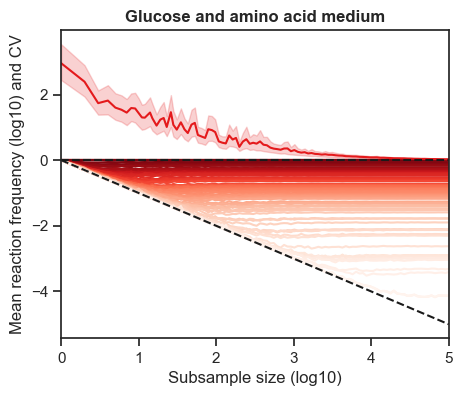

In [131]:
sns.set_theme(context='notebook', style='ticks', font_scale=1)

# Plot convergence of reaction frequencies

df = bs_df

# s = random.sample(list(set(df[(df.n == df.n.max()) & (df.frac != 1)].reaction)), 10)
# s = set(df[(df.n == df.n.max()) & (df.frac != 1)].reaction)
# s = random.sample(list(set(df.reaction)), 100)
s = set(df.reaction)

f = plt.figure()

df = df[df.reaction.isin(s)]
hue_order = list(df.groupby(['reaction']).frac.mean().sort_values(ascending=False).index)

ax = sns.lineplot(x='log_n', y='log_frac', hue='reaction', hue_order=hue_order, data=df, errorbar=None, palette='Reds_r')

plt.plot([0, df.log_n.max()], [0, -df.log_n.max()], c='k', ls='--')

# ax = sns.lineplot(x='log_n', y='frac_rel', data=df)

g = bs_df.groupby(['reaction', 'log_n'])
df = g.frac_rel.std().reset_index()
df.frac_rel /= g.frac_rel.mean().values

sns.lineplot(x=df.log_n, y=df.frac_rel, color='#e41a1c')

plt.plot([0, df.log_n.max()], [0, 0], c='k', ls='--')

# plt.xscale('log')
# plt.yscale('log')

plt.xlim(0, 5)
# plt.ylim(-5, 3)

t = 'Minimal glucose' if medium == 'min_glc' else 'Glucose and amino acid'
plt.title(t + ' medium', weight='bold')
plt.xlabel('Subsample size (log10)')
# plt.ylabel('Mean reaction frequency (log10)    Mean CV (log10)', loc='bottom')
plt.ylabel('Mean reaction frequency (log10) and CV', loc='center')
# ax.text(-1, 0, 'Relative CV (log10)', rotation=90)

# ax.set_yticklabels(['$10^{' + x.get_text() + '}$' for x in ax.get_yticklabels()])

# plt.grid(ls='--')

ax.legend().set_visible(False)

f.set_size_inches(5, 4)
f.savefig(join(results_dir, 'sampling_convergence_' + medium + '.svg'), bbox_inches='tight')

## Analyze gene frequencies

### Convert MP samples from reactions to genes

In [193]:
# Convert samples from reactions to genes (maximum for each gene)

gene_samples = []

for i, s in enumerate(samples):
    if i and not i % 10000:
        print(i)

    # Sum fraction of isozymes for each gene and reaction
    d = defaultdict(dict)

    for r_id in s:
        if r_id.endswith('_rev'):
            r_id = r_id[:-4]
        r = model.reactions.get_by_id(r_id)

        ors = r.gene_reaction_rule.split(' or ')
        for x in ors:
            for b in re.findall('b\\d{4}', x):
                try:
                    d[b][r.id] += 1 / len(ors)
                except KeyError:
                    d[b][r.id] = 1 / len(ors)
    
    # Compute maximum fraction of isozymes for each gene
    gs = {b: np.max(list(d[b].values())) for b in d}
    # gs = {b: np.sum(list(d[b].values())) for b in d}
    gene_samples.append(gs)

gene_sample_df = pd.DataFrame(gene_samples).fillna(0)
gene_sample_df

10000
20000
30000
40000
50000
60000
70000
80000
90000


b3919  b3736  b3737  b3738  b3731  b3732  b3733  b3734  b3735  b3739  \
0        1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    0.5   
1        1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    0.5   
2        1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    0.5   
3        1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4        1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    0.5   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
99995    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    0.5   
99996    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    0.5   
99997    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    0.5   
99998    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    0.5   
99999    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

       ...  b0356  b2241  b2242  b2243  b3605  b0306  b0307  b0308  b3426  \
0      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
99995  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
99996  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
99997  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
99998  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
99999  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

       b3945  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0  
...      ...  
99995    0.0  
99996    0.0  
99997    0.0  
99998    0.0  
99999    0.0  

[100000 rows x 160 columns]

In [194]:
# # Convert samples from reactions to genes (inclusion-exclusion principle)

# gene_samples = []

# for i, s in enumerate(samples):
#     if i and not i % 10000:
#         print(i)

#     # Sum fraction of isozymes for each gene and reaction
#     d = defaultdict(dict)

#     for r_id in s:
#         if r_id.endswith('_rev'):
#             r_id = r_id[:-4]
#         r = model.reactions.get_by_id(r_id)

#         ors = r.gene_reaction_rule.split(' or ')
#         for x in ors:
#             for b in re.findall('b\\d{4}', x):
#                 try:
#                     d[b][r.id] += 1 / len(ors)
#                 except KeyError:
#                     d[b][r.id] = 1 / len(ors)
    
#     gs = defaultdict(float)
#     for b, reactions in d.items():
#         n = len(reactions)
#         # print()
#         # print(b)
#         # print(n)
#         for j in range(1, n + 1):
#             for r in combinations(reactions, j):
#                 # print(r)
#                 # if len(r) == 1:
#                 #     f = 1
#                 # else:
#                 f = sample_df[list(r)].all(1).sum() / len(sample_df)
#                 # print(f)
#                 # print([d[b][x] for x in r])
#                 f *= np.product([d[b][x] for x in r])
#                 # print(f)
#                 # f = np.product([d[b][x] for x in r])
#                 if j % 2:
#                     gs[b] += f
#                 else:
#                     gs[b] -= f

#     # gs = {b: np.max(list(d[b].values())) for b in d}
#     gene_samples.append(gs)

#     # break

# gene_sample_df = pd.DataFrame(gene_samples).fillna(0)
# gene_sample_df

In [196]:
# Compute gene frequencies
gene_frac = defaultdict(float)
gene_frac.update(dict(gene_sample_df.sum() / len(gene_sample_df)))
gene_frac

defaultdict(float,
            {'b3919': 0.93043,
             'b3736': 0.68255,
             'b3737': 0.68255,
             'b3738': 0.68255,
             'b3731': 0.68255,
             'b3732': 0.68255,
             'b3733': 0.68255,
             'b3734': 0.68255,
             'b3735': 0.68255,
             'b3739': 0.341275,
             'b0721': 0.24367,
             'b0722': 0.24367,
             'b0723': 0.24367,
             'b0724': 0.24367,
             'b1474': 0.07425,
             'b1475': 0.07425,
             'b1476': 0.07425,
             'b3892': 0.07425,
             'b3893': 0.07425,
             'b3894': 0.07425,
             'b0720': 1.0,
             'b2744': 0.15722666666666665,
             'b4226': 0.15722666666666665,
             'b2502': 0.15722666666666665,
             'b3608': 1.0,
             'b3916': 0.69662,
             'b1723': 0.25348,
             'b4069': 0.39365,
             'b1109': 0.18792,
             'b2463': 0.10281,
             'b0118': 

### Predict growth effects of single gene knockouts with MOMA

In [197]:
# Set growth and non-growth associated maintenance requirements
bm.lower_bound = 0
# atpm.bounds = 0, 0

In [198]:
# Compute wild-type growth rate with FBA
model.objective = bm
wt_growth = model.optimize().objective_value
wt_growth

0.46769359708757835

In [199]:
# Single gene deletion analysis with linear MOMA
gd_df = cobra.flux_analysis.single_gene_deletion(model, method='linear moma')
gd_df.index = [next(iter(x)) for x in gd_df.ids]
gd_df

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-27
Read LP format model from file /var/folders/0z/0wtrv7xn7yq6df17wtbwn69c0000gn/T/tmp1i3oigl3.lp
Reading time = 0.03 seconds
: 6972 rows, 7750 columns, 35867 nonzeros
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-27
Read LP format model from file /var/folders/0z/0wtrv7xn7yq6df17wtbwn69c0000gn/T/tmpbtxhabw4.lp
Reading time = 0.03 seconds
: 6972 rows, 7750 columns, 35867 nonzeros
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-27
Read LP format model from file /var/folders/0z/0wtrv7xn7yq6df17wtbwn69c0000gn/T/tmpbh62t48v.lp
Reading time = 0.03 seconds
: 6972 rows, 7750 columns, 35867 nonzeros
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-27
Read LP format model from file /var/folders/0z/0wtrv7xn7yq6df17wtbwn69c0000gn/T/tmpc46svn4z.lp
Reading time = 0.03 seconds
: 6972 rows, 7750 

ids    growth   status
b3730  {b3730}  0.000000  optimal
b0954  {b0954}  0.467694  optimal
b1008  {b1008}  0.467694  optimal
b4240  {b4240}  0.467694  optimal
b3856  {b3856}  0.467694  optimal
...        ...       ...      ...
b2557  {b2557}  0.000000  optimal
b1991  {b1991}  0.467694  optimal
b4384  {b4384}  0.467694  optimal
b0369  {b0369}  0.000000  optimal
b1244  {b1244}  0.467694  optimal

[1367 rows x 3 columns]

### Compare predictions to single gene knockout data

In [212]:
# Add reaction frequencies from sampled MPs
gene_df['gene_frac'] = [gene_frac[b] if b in ccm_genes else np.nan for b in gene_df.b]

# Add FBA predictions
gene_df['growth_fba'] = [gd_df.loc[b].growth if b in gd_df.index else np.nan for b in gene_df.b]
gene_df['essential_fba'] = gene_df.growth_fba < 1e-6
gene_df['gene_frac_fba'] = 1 - gene_df.growth_fba / model.optimize().objective_value
gene_df.loc[gene_df.gene_frac_fba < 1e-6, 'gene_frac_fba'] = 0

gene_df

eck  gene      jw      b  percent   lb22  mops24  mops48  score  \
0     ECK0001  thrL  JW4367  b0001     87.5  0.848   0.355   0.542   -2.5   
1     ECK0002  thrA  JW0001  b0002     75.0  0.793   0.023   0.040   -3.0   
2     ECK0003  thrB  JW0002  b0003     75.0  0.682   0.004   0.010   -2.5   
3     ECK0004  thrC  JW0003  b0004     62.5  0.625   0.000   0.000   -3.0   
4     ECK0005  yaaX  JW0004  b0005    100.0  0.836   0.382   0.469   -2.0   
...       ...   ...     ...    ...      ...    ...     ...     ...    ...   
4373  ECK4391  creC  JW4362  b4399     75.0  0.743   0.249   0.176   -4.0   
4374  ECK4392  creD  JW4363  b4400    100.0  0.803   0.334   0.328   -4.0   
4375  ECK4393  arcA  JW4364  b4401     87.5  0.741   0.395   0.505   -2.5   
4376  ECK4394  yjjY  JW4365  b4402    100.0  0.781   0.817   0.457   -1.5   
4377  ECK4395  yjtD  JW4366  b4403     87.5  0.743   0.339   0.479   -3.0   

      essential_keio  gene_frac  growth_fba  essential_fba  gene_frac_fba  
0              False        NaN         NaN          False            NaN  
1              False        NaN    0.467694          False            0.0  
2              False        NaN    0.000000           True            1.0  
3              False        NaN    0.000000           True            1.0  
4              False        NaN         NaN          False            NaN  
...              ...        ...         ...            ...            ...  
4373           False        NaN         NaN          False            NaN  
4374           False        NaN         NaN          False            NaN  
4375           False        NaN         NaN          False            NaN  
4376           False        NaN         NaN          False            NaN  
4377           False        NaN         NaN          False            NaN  

[4378 rows x 14 columns]

(-0.4918472144036361, 1.5957150334343113e-18)

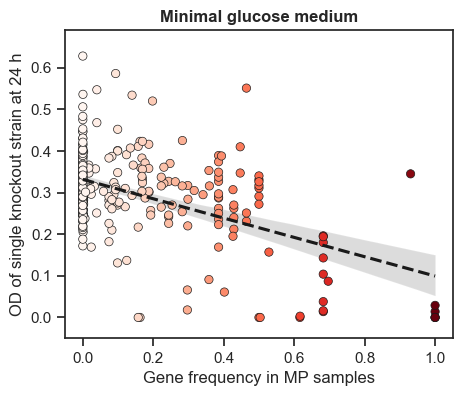

In [213]:
sns.set_theme(context='notebook', style='ticks', font_scale=1)

f = plt.figure()

df = gene_df.dropna()

x = df.gene_frac
y = df.mops24
hue = df.gene_frac

ax = sns.regplot(x=x, y=y, scatter_kws=dict(color='w'), color='k', line_kws=dict(ls='--'))
ax = sns.scatterplot(x=x, y=y, hue=hue, palette='Reds', ec='k')

t = 'Minimal glucose' if medium == 'min_glc' else 'Glucose and amino acid'
plt.title(t + ' medium', weight='bold')
plt.xlabel('Gene frequency in MP samples')
plt.ylabel('OD of single knockout strain at 24 h')

ax.legend().set_visible(False)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 0.69)

r, p = pearsonr(x, y)
# plt.text(0.75, 0.25, '$r = {:.2f}$'.format(r))

f.set_size_inches(5, 4)
f.savefig(join(results_dir, 'growth_gene_frequency_' + medium + '.svg'), bbox_inches='tight')

r, p

/var/folders/0z/0wtrv7xn7yq6df17wtbwn69c0000gn/T/ipykernel_66320/935681067.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = yp
/var/folders/0z/0wtrv7xn7yq6df17wtbwn69c0000gn/T/ipykernel_66320/935681067.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['residual'] = res
/var/folders/0z/0wtrv7xn7yq6df17wtbwn69c0000gn/T/ipykernel_66320/935681067.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

eck  gene      jw      b  percent   lb22  mops24  mops48  score  \
7     ECK0008  talB  JW0007  b0008    100.0  0.788   0.254   0.169   -3.0   
110   ECK0113  aceE  JW0110  b0114     75.0  0.834   0.353   0.270   -3.0   
111   ECK0114  aceF  JW0111  b0115     62.5  0.771   0.091   0.296   -2.0   
112   ECK0115   lpd  JW0112  b0116     75.0  0.337   0.061   0.138   -2.0   
114   ECK0117  acnB  JW0114  b0118     62.5  0.704   0.331   0.387   -3.0   
...       ...   ...     ...    ...      ...    ...     ...     ...    ...   
4198  ECK4225  ytfT  JW5753  b4230     25.0  0.946   0.290   0.362   -2.0   
4199  ECK4226  yjfF  JW5754  b4231    100.0  0.887   0.235   0.272   -3.0   
4200  ECK4227   fbp  JW4191  b4232    100.0  0.313   0.301   0.314   -4.0   
4273  ECK4290  sgcE  JW4263  b4301    100.0  0.756   0.410   0.578   -2.5   
4369  ECK4387  ytjC  JW4358  b4395     75.0  0.740   0.339   0.378   -4.0   

      essential_keio  gene_frac  growth_fba  essential_fba  gene_frac_fba  \
7              False   0.282245    0.467694          False       0.000000   
110            False   0.358000    0.435440          False       0.068964   
111            False   0.358000    0.435440          False       0.068964   
112            False   0.401870    0.403566          False       0.137114   
114            False   0.500000    0.467694          False       0.000000   
...              ...        ...         ...            ...            ...   
4198           False   0.000000    0.467694          False       0.000000   
4199           False   0.000000    0.467694          False       0.000000   
4200           False   0.007787    0.467694          False       0.000000   
4273           False   0.446765    0.467694          False       0.000000   
4369           False   0.167810    0.467694          False       0.000000   

          pred  residual  residual_norm  
7     0.266063 -0.012063      -0.130978  
110   0.248479  0.104521       1.134893  
111   0.248479 -0.157479      -1.709916  
112   0.238296 -0.177296      -1.925092  
114   0.215519  0.115481       1.253895  
...        ...       ...            ...  
4198  0.331575 -0.041575      -0.451424  
4199  0.331575 -0.096575      -1.048617  
4200  0.329768 -0.028768      -0.312361  
4273  0.227876  0.182124       1.977514  
4369  0.292624  0.046376       0.503548  

[281 rows x 17 columns]

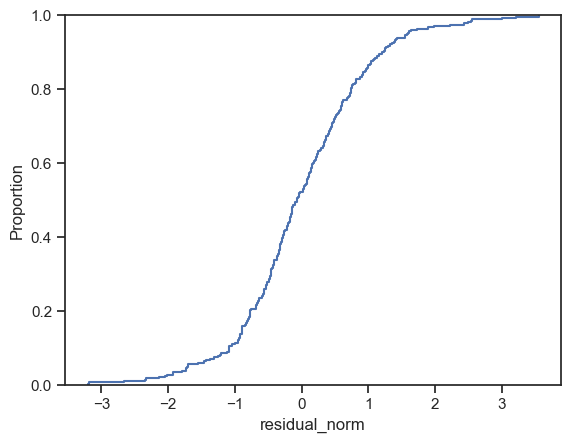

In [202]:
# Compute regression residual for each gene

df = gene_df.dropna()

lr = LinearRegression()
lr.fit(np.array([[v] for v in x]), np.array(y))

yp = lr.predict(np.array([[v] for v in df.gene_frac]))
df['pred'] = yp

res = y - yp
df['residual'] = res

res = (res - res.mean()) / res.std()
df['residual_norm'] = res

sns.ecdfplot(df.residual_norm)

res_df = df
res_df

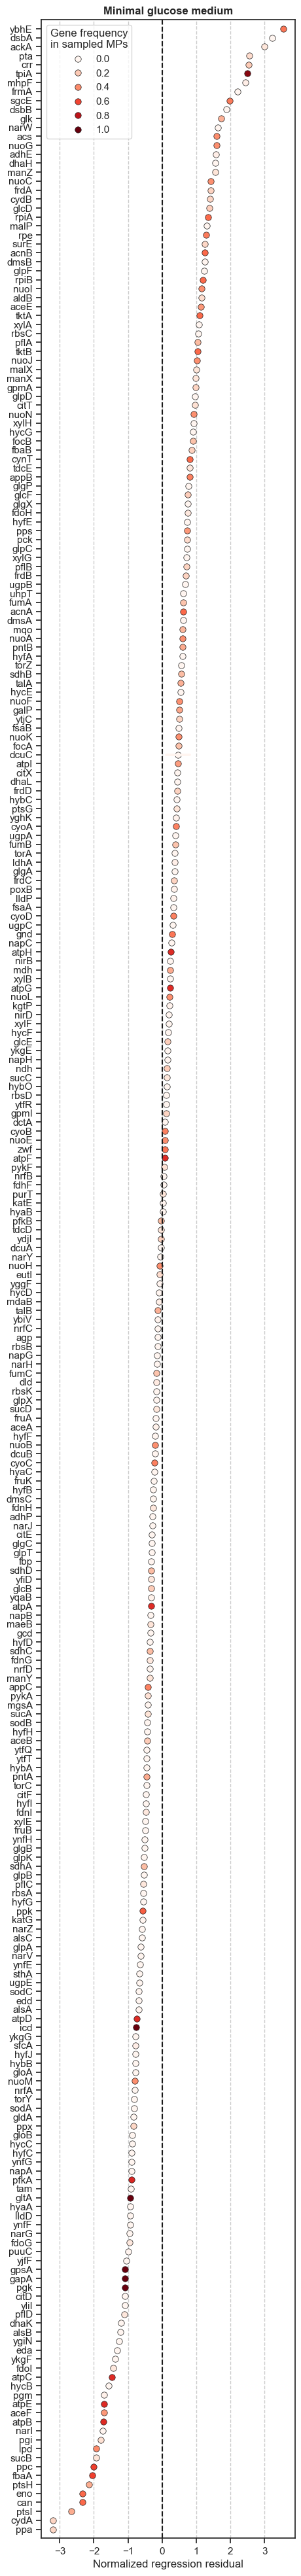

In [203]:
# Plot regression residuals by gene

f = plt.figure()

df = res_df

order = list(df.groupby('gene').residual.mean().sort_values(ascending=False).index)
ax = sns.pointplot(y='gene', x='residual_norm', data=df, linestyle='none', order=order, hue='gene_frac', dodge=False, palette='Reds', mec='k', mew=0.5)

ylim = df.gene.nunique(), -1

plt.plot([0] * 2, ylim, c='k', ls='--')

plt.ylim(ylim)
plt.grid(True, ls='--', axis='x')

t = 'Minimal glucose' if medium == 'min_glc' else 'Glucose and amino acid'
plt.title(t + ' medium', weight='bold')
plt.xlabel('Normalized regression residual')
plt.ylabel('')

ax.legend(title='Gene frequency\nin sampled MPs')

f.set_size_inches(5, 50)
f.savefig(join(results_dir, 'gene_residuals_' + medium + '.pdf'), bbox_inches='tight')

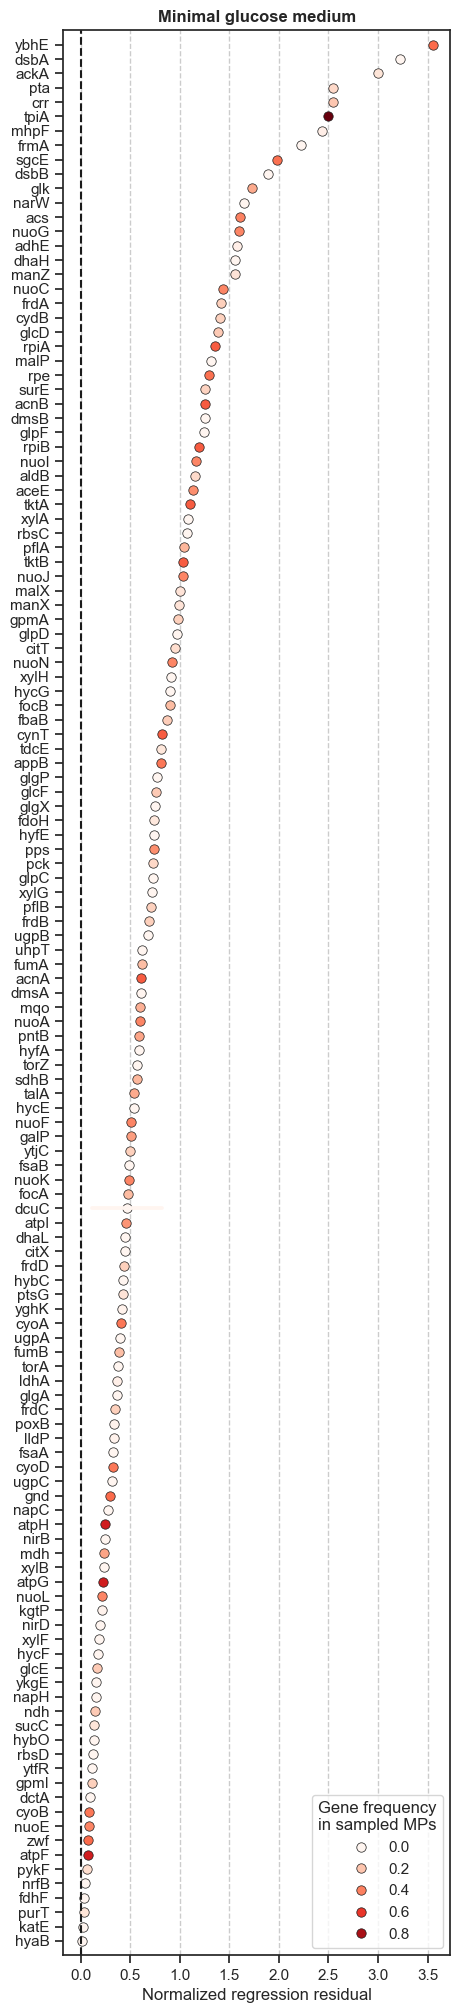

In [204]:
# Plot positive regression residuals by gene

f = plt.figure()

df = res_df
df = df[df.residual >= 0]

order = list(df.groupby('gene').residual.mean().sort_values(ascending=False).index)
ax = sns.pointplot(y='gene', x='residual_norm', data=df, linestyle='none', order=order, hue='gene_frac', dodge=False, palette='Reds', mec='k', mew=0.5)

ylim = df.gene.nunique(), -1

plt.plot([0] * 2, ylim, c='k', ls='--')

plt.ylim(ylim)
plt.grid(True, ls='--', axis='x')

t = 'Minimal glucose' if medium == 'min_glc' else 'Glucose and amino acid'
plt.title(t + ' medium', weight='bold')
plt.xlabel('Normalized regression residual')
plt.ylabel('')

ax.legend(title='Gene frequency\nin sampled MPs')

f.set_size_inches(5, 25)
f.savefig(join(results_dir, 'gene_residuals_pos_' + medium + '.svg'), bbox_inches='tight')

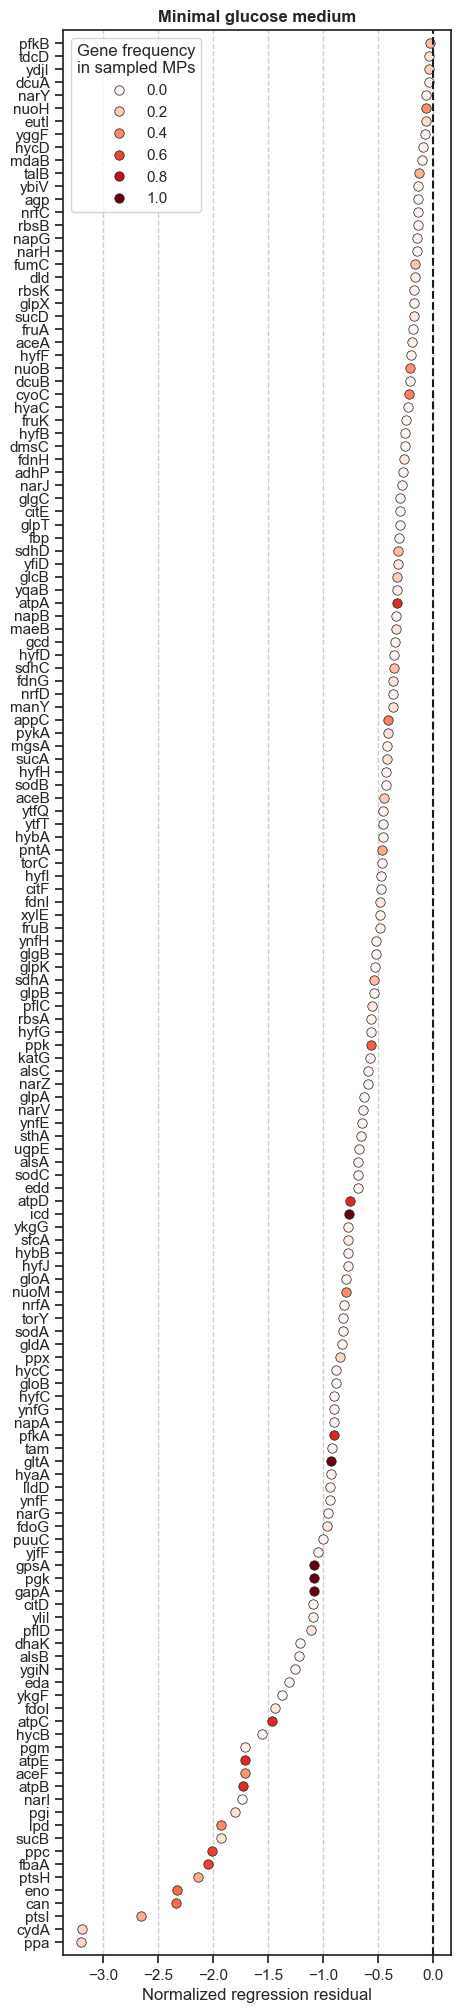

In [205]:
# Plot negatvie residuals by gene and sign

f = plt.figure()

df = res_df
df = df[df.residual < 0]

order = list(df.groupby('gene').residual.mean().sort_values(ascending=False).index)
ax = sns.pointplot(y='gene', x='residual_norm', data=df, linestyle='none', order=order, hue='gene_frac', dodge=False, palette='Reds', mec='k', mew=0.5)

ylim = df.gene.nunique(), -1

plt.plot([0] * 2, ylim, c='k', ls='--')

plt.ylim(ylim)
plt.grid(True, ls='--', axis='x')

t = 'Minimal glucose' if medium == 'min_glc' else 'Glucose and amino acid'
plt.title(t + ' medium', weight='bold')
plt.xlabel('Normalized regression residual')
plt.ylabel('')

ax.legend(title='Gene frequency\nin sampled MPs')

f.set_size_inches(5, 25)
f.savefig(join(results_dir, 'gene_residuals_neg_' + medium + '.svg'), bbox_inches='tight')

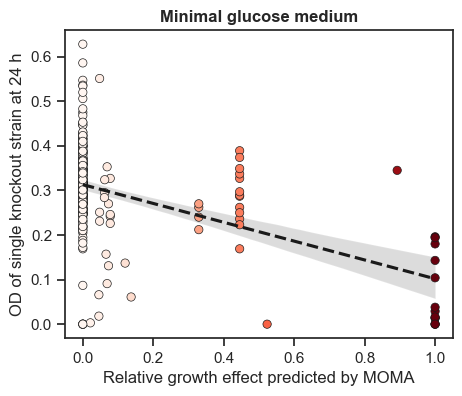

In [206]:
f = plt.figure()

df = gene_df.dropna()

x = df.gene_frac_fba
y = df.mops24
hue = df.gene_frac_fba

ax = sns.regplot(x=x, y=y, scatter_kws=dict(color='w'), color='k', line_kws=dict(ls='--'))
ax = sns.scatterplot(x=x, y=y, hue=hue, palette='Reds', ec='k')

t = 'Minimal glucose' if medium == 'min_glc' else 'Glucose and amino acid'
plt.title(t + ' medium', weight='bold')
plt.xlabel('Relative growth effect predicted by MOMA')
plt.ylabel('OD of single knockout strain at 24 h')

ax.legend().set_visible(False)

# r, p = pearsonr(x, y)
# plt.text(0.75, 0.25, '$r = {:.2f}$'.format(r))

f.set_size_inches(5, 4)
f.savefig(join(results_dir, 'growth_gene_fba_' + medium + '.svg'), bbox_inches='tight')

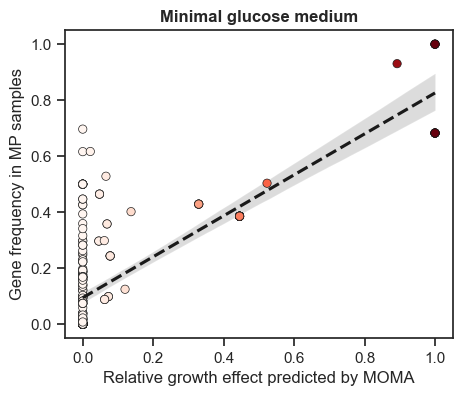

In [207]:
f = plt.figure()

df = gene_df.dropna()

x = df.gene_frac_fba
y = df.gene_frac
hue = df.gene_frac_fba

ax = sns.regplot(x=x, y=y, scatter_kws=dict(color='w'), color='k', line_kws=dict(ls='--'))
ax = sns.scatterplot(x=x, y=y, hue=hue, palette='Reds', ec='k')

t = 'Minimal glucose' if medium == 'min_glc' else 'Glucose and amino acid'
plt.title(t + ' medium', weight='bold')
plt.xlabel('Relative growth effect predicted by MOMA')
plt.ylabel('Gene frequency in MP samples')

ax.legend().set_visible(False)

# r, p = pearsonr(x, y)
# plt.text(0.75, 0.25, '$r = {:.2f}$'.format(r))

f.set_size_inches(5, 4)
f.savefig(join(results_dir, 'gene_frequency_fba_' + medium + '.svg'), bbox_inches='tight')

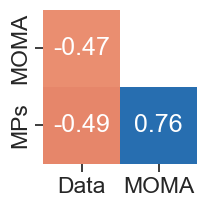

In [208]:
sns.set_theme(context='notebook', style='ticks', font_scale=1.5)

f = plt.figure()

df = gene_df
df = df[['mops24', 'gene_frac_fba', 'gene_frac']].dropna()

df = df.corr() * np.tril(np.ones([df.shape[1]] * 2), k=-1)
df = df.loc[df.any(axis=1), df.any(axis=0)]
mask = 1 - np.tril(np.ones([df.shape[1]] * 2))

ax = sns.heatmap(df, annot=True, cmap='RdBu', center=0, mask=mask, cbar=False, square=True, vmax=1, vmin=-1)

# labels = ['Data', 'FBA',  'MPs']
# ax.set_xticklabels(labels)
# ax.set_yticklabels(labels)

ax.set_xticklabels(['Data',  'MOMA'])
ax.set_yticklabels(['MOMA',  'MPs'])

f.set_size_inches(2, 2)
f.savefig(join(results_dir, 'gene_frequency_corr_' + medium + '.svg'), bbox_inches='tight')

In [219]:
if medium == 'min_glc':
    # Write gene frequency supplementary table
    df = gene_df.dropna()
    df = df[['b', 'gene', 'gene_frac', 'gene_frac_fba']]
    df.columns = ['id', 'name', 'frequency_mp', 'frequency_moma']
    df.to_excel(join(results_dir, 'gene_frequency.xlsx'), index=False)

## Analyze gene set frequencies

### Convert MP samples from reactions to gene sets

In [252]:
# Convert samples from reactions to KOs (very slow)

ko_samples = []

for i, s in enumerate(samples):
    if i and not i % 1000:
        print(i)

    d = defaultdict(dict)
             
    for r_id in s:
        if r_id.endswith('_rev'):
            r_id = r_id[:-4]
        r = model.reactions.get_by_id(r_id)

        ors = r.gene_reaction_rule.split(' or ')
        for x in ors:
            # for ko in set().union(*ko_pairs):
            for ko in set(frozenset().union(*ko_pair) for ko_pair in ko_pairs):
                s = ko & set(re.findall('b\\d{4}', x))
                if s:
                    try:
                        d[ko][r.id] += 1 / len(ors)
                    except KeyError:
                        d[ko][r.id] = 1 / len(ors)


    # Compute maximum fraction of isozymes for each KO
    ks = {ko: np.max(list(d[ko].values())) for ko in d}
    ko_samples.append(ks)

ko_sample_df = pd.DataFrame(ko_samples).fillna(0)
ko_sample_df

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000


(b3919, b1479, b2463)  (b3919, b1676, b1854)  (b3919, b1852)  \
0                        1.0                    1.0             1.0   
1                        1.0                    0.0             1.0   
2                        1.0                    1.0             1.0   
3                        1.0                    1.0             1.0   
4                        1.0                    1.0             1.0   
...                      ...                    ...             ...   
99995                    1.0                    0.0             0.0   
99996                    1.0                    1.0             1.0   
99997                    1.0                    1.0             1.0   
99998                    1.0                    1.0             1.0   
99999                    1.0                    0.0             1.0   

       (b3919, b3403, b3956)  (b3919, b0008, b2464)  (b3919, b4015)  \
0                        1.0                    1.0             1.0   
1                        1.0                    1.0             0.0   
2                        1.0                    1.0             1.0   
3                        1.0                    1.0             1.0   
4                        1.0                    1.0             1.0   
...                      ...                    ...             ...   
99995                    0.0                    1.0             0.0   
99996                    1.0                    1.0             1.0   
99997                    1.0                    1.0             1.0   
99998                    1.0                    1.0             1.0   
99999                    0.0                    1.0             0.0   

       (b3919, b4025)  (b4015, b2464)  (b0008, b3612, b2464)  \
0                 1.0             0.5                    1.0   
1                 0.0             0.5                    1.0   
2                 1.0             0.5                    1.0   
3                 1.0             1.0                    0.0   
4                 1.0             0.5                    1.0   
...               ...             ...                    ...   
99995             0.0             0.5                    1.0   
99996             1.0             0.5                    1.0   
99997             1.0             0.5                    1.0   
99998             1.0             1.0                    0.0   
99999             0.0             0.5                    1.0   

       (b2463, b1479, b2464)  ...  (b4025, b0755, b3612)  (b4025, b0114)  \
0                        0.5  ...               0.000000             0.0   
1                        1.0  ...               0.000000             0.0   
2                        0.5  ...               0.000000             0.0   
3                        0.0  ...               0.000000             0.0   
4                        0.5  ...               0.000000             0.0   
...                      ...  ...                    ...             ...   
99995                    1.0  ...               0.666667             0.0   
99996                    0.5  ...               0.000000             0.0   
99997                    0.5  ...               1.000000             1.0   
99998                    0.0  ...               0.000000             1.0   
99999                    1.0  ...               0.000000             1.0   

       (b1479, b1676, b1854)  (b1676, b1854, b0114)  (b0115, b1676, b1854)  \
0                        0.0                    0.0                    0.0   
1                        0.0                    0.0                    0.0   
2                        0.0                    0.0                    0.0   
3                        0.0                    0.0                    0.0   
4                        0.0                    0.0                    0.0   
...                      ...                    ...                    ...   
99995                    0.0                    0.0                    0.

In [253]:
# Compute gene set frequencies
ko_frac = defaultdict(float)
ko_frac.update(dict(ko_sample_df.sum() / len(ko_sample_df)))
ko_frac

defaultdict(float,
            {frozenset({'b1479', 'b2463', 'b3919'}): 0.90711,
             frozenset({'b1676', 'b1854', 'b3919'}): 0.78888,
             frozenset({'b1852', 'b3919'}): 0.86293,
             frozenset({'b3403', 'b3919', 'b3956'}): 0.90973,
             frozenset({'b0008', 'b2464', 'b3919'}): 0.89759,
             frozenset({'b3919', 'b4015'}): 0.78768,
             frozenset({'b3919', 'b4025'}): 0.78964,
             frozenset({'b2464', 'b4015'}): 0.327325,
             frozenset({'b0008', 'b2464', 'b3612'}): 0.6158800000000001,
             frozenset({'b1479', 'b2463', 'b2464'}): 0.524085,
             frozenset({'b2464', 'b3403', 'b3956'}): 0.66535,
             frozenset({'b0008', 'b1702', 'b2464'}): 0.70304,
             frozenset({'b0008', 'b1723', 'b2464'}): 0.70404,
             frozenset({'b0008', 'b2097', 'b2464'}): 0.66028,
             frozenset({'b1852', 'b2464'}): 0.586725,
             frozenset({'b0008', 'b0116', 'b2464'}): 0.77443,
             frozens

### Predict growth effects of multiple gene knockouts with MOMA

In [254]:
# Set growth and non-growth associated maintenance requirements
bm = model.reactions.BIOMASS_Ec_iJO1366_core_53p95M
atpm = model.reactions.ATPM
bm.lower_bound = 0
# atpm.bounds = 0, 0

In [255]:
# Compute wild-type growth rate with FBA
model.objective = bm
wt_growth = model.optimize().objective_value
wt_growth

0.9728026819421632

In [256]:
# d = defaultdict(list)

# for ko_pair in ko_pairs:
#     ko = set().union(*ko_pair)
#     ids, growth, status = cobra.flux_analysis.deletion._gene_deletion(model, ko)
#     d['ids'].append(ids)
#     d['growth'].append(growth)
#     d['status'].append(status)

# gd_df = pd.DataFrame(d)
# # gd_df.index = ko_pairs

# gd_df

In [257]:
# Predict multiple KO growth rates with MOMA (very slow even for linear)

# Get pFBA reference solution for MOMA
s0 = cobra.flux_analysis.pfba(model)

d = defaultdict(list)

for i, ko_pair in enumerate(ko_pairs):
    print(i)
    with model:
        # Knock out genes and solve MOMA
        ko = list(set().union(*ko_pair))
        cobra.manipulation.delete.knock_out_model_genes(model, ko)
        s = cobra.flux_analysis.moma(model, solution=s0, linear=True)

        d['ids'].append(frozenset(ko))
        d['growth'].append(s[bm.id])
        d['status'].append(s.status)
        # break

gd_df = pd.DataFrame(d)
# gd_df.index = ko_pairs

gd_df

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204


ids    growth   status
0           (b4025, b0114)  0.859422  optimal
1           (b1852, b0114)  0.888385  optimal
2           (b4015, b0114)  0.910655  optimal
3    (b2463, b1479, b0114)  0.910655  optimal
4    (b0114, b3403, b3956)  0.923657  optimal
..                     ...       ...      ...
200         (b1852, b4015)  0.957779  optimal
201  (b1852, b1479, b2463)  0.961055  optimal
202  (b1852, b3403, b3956)  0.957513  optimal
203  (b1852, b0008, b2464)  0.939791  optimal
204  (b1852, b1676, b1854)  0.941836  optimal

[205 rows x 3 columns]

### Compare predictions to multiple gene knockout data

In [259]:
# pair_df['gene_1_mops24'] = [gene_df[gene_df.gene == ko_map[x][0]].mops24.iloc[0] for x in pair_df.gene_1]

# pair_df['gene_1_frac'] = [gene_frac[gene_map[ko_map[x][0]]] for x in pair_df.gene_1]
# pair_df['gene_2_frac'] = [gene_frac[gene_map[ko_map[x][0]]] for x in pair_df.gene_2]

pair_df['ko_frac'] = [ko_frac[frozenset().union(*ko_pair)] for ko_pair in ko_pairs]

pair_df['growth_fba'] = gd_df.growth
pair_df['ko_frac_fba'] = 1 - pair_df.growth_fba / wt_growth

pair_df

index  case_no  strain_no  medium_no carbon_source control  w_pre  \
0      117      118       10.0        1.0       Glucose     NaN    NaN   
1      130      131       11.0        1.0       Glucose     NaN    NaN   
2      143      144       12.0        1.0       Glucose     NaN    NaN   
3      156      157       13.0        1.0       Glucose     NaN    NaN   
4      169      170       14.0        1.0       Glucose     NaN    NaN   
..     ...      ...        ...        ...           ...     ...    ...   
200   3263     3264      252.0        1.0       Glucose     NaN    NaN   
201   3276     3277      253.0        1.0       Glucose     NaN    NaN   
202   3289     3290      254.0        1.0       Glucose     NaN    NaN   
203   3302     3303      255.0        1.0       Glucose     NaN    NaN   
204   3315     3316      256.0        1.0       Glucose     NaN    NaN   

      w_24h   w_48h  w_24h_rel  ...      w_mu    w_mu_2      rgie      rgis  \
0    0.0827  0.5218   0.218610  ...  0.225765  0.172194 -0.800386  0.000000   
1   -0.0007  0.0139  -0.001850  ...  0.225765  0.172194 -1.002007  0.000000   
2   -0.0012 -0.0008  -0.003172  ...  0.225765  0.172194 -1.003429  0.000000   
3    0.0025  0.0573   0.006609  ...  0.225765  0.172194 -0.992733  0.000000   
4    0.0019  0.0087   0.005022  ...  0.225765  0.172194 -0.992523  0.000000   
..      ...     ...        ...  ...       ...       ...       ...       ...   
200  0.3273  0.3463   0.865186  ...  0.998724  0.998724 -0.064857  0.000000   
201  0.3195  0.3287   0.844568  ...  0.998724  0.998724 -0.071221  0.000000   
202  0.2380  0.2175   0.629130  ...  0.636480  0.636480 -0.063361  0.000000   
203  0.3323  0.3441   0.878403  ...  0.895408  0.895408 -0.070229 -0.103448   
204  0.3597  0.3263   0.950833  ...  0.989796  0.989796 -0.013710  0.000000   

       rgis_2  gene_1    gene_2  ko_frac growth_fba  ko_frac_fba  
0    0.000000    aceE       pgi  0.48086   0.859422     0.116551  
1    0.000000    aceE       zwf  0.69341   0.888385     0.086778  
2    0.000000    aceE      aceA  0.43686   0.910655     0.063885  
3    0.000000    aceE        ME  0.58084   0.910655     0.063885  
4    0.000000    aceE  ppc_pckA  0.72944   0.923657     0.050519  
..        ...     ...       ...      ...        ...          ...  
200  0.000000     zwf      aceA  0.50694   0.957779     0.015443  
201  0.000000     zwf        ME  0.65050   0.961055     0.012076  
202  0.000000     zwf  ppc_pckA  0.75202   0.957513     0.015717  
203 -0.103448     zwf       Tal  0.71492   0.939791     0.033934  
204  0.000000     zwf       Pyk  0.57599   0.941836     0.031832  

[205 rows x 22 columns]

(PearsonRResult(statistic=-0.45409496954860057, pvalue=8.003034137260768e-12),
 SignificanceResult(statistic=-0.4908422780912783, pvalue=7.926957650560516e-14))

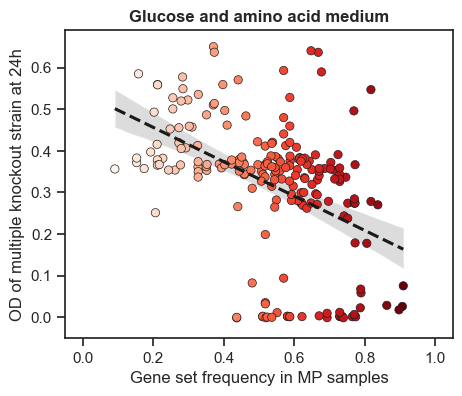

In [261]:
sns.set_theme(context='notebook', style='ticks', font_scale=1)

df = pair_df
# df = df[df.gene_2 == 'control']
# df = df[~df.gene_1.isin(['aceE', 'aceF', 'lpdA', 'rpiA'])]
# df = df[~df.gene_1.isin(['aceE', 'aceF', 'lpdA', 'tktA', 'tktB'])]
# df = df[~df.gene_1.isin(['aceE', 'aceF', 'lpdA', 'rpiA'])]
# df = df[~df.gene_1.isin(['pfkA'])]
# df = df[~df.gene_2.isin(['pgi'])]
# df = df[~df[['gene_1', 'gene_2']].isin(['zwf', 'pgi']).all(1)]
# df = df[~(df[['gene_1', 'gene_2']].isin(['zwf', 'pgi', 'rpe']).sum(1) == 2)]
# df = df[~df.gene_2.isin(['Tal'])]

x = df.ko_frac
y = df.w_24h
hue = df.ko_frac
# hue = None
# hue = df.gene_1_mops24
# hue = df.ko_frac < 0.43
# hue = df.gene_2
# hue = df.rgie
# hue = df.gene_1.isin(['pfkA'])
# hue = df.gene_1.isin(['tktA', 'tktB'])
# hue = df.gene_1.isin(['aceE', 'aceF', 'lpdA', 'rpiA'])
# hue += df[['gene_1', 'gene_2']].isin(['zwf', 'pgi', 'rpe']).sum(1) == 2
# hue = df.gene_1.isin(['aceE', 'aceF', 'lpdA']) | df[['gene_1', 'gene_2']].isin(['zwf', 'pgi']).all(1)
# hue = df.residual.abs() > 0.2

f = plt.figure()

ax = sns.regplot(x=x, y=y, scatter_kws=dict(color='w'), color='k', line_kws=dict(ls='--'))
ax = sns.scatterplot(x=x, y=y, hue=hue, palette='Reds', ec='k')
# palette='Reds'
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 0.69)

plt.title('Glucose and amino acid medium', weight='bold')
plt.xlabel('Gene set frequency in MP samples')
plt.ylabel('OD of multiple knockout strain at 24h')

ax.legend().set_visible(False)

f.set_size_inches(5, 4)
# f.savefig(join(results_dir, 'ko_frequency_' + medium + '.svg'), bbox_inches='tight')

pearsonr(x, y), spearmanr(x, y)

In [262]:
df = pair_df
df[(df.ko_frac < 0.6) & (df.w_24h < 0.1)].gene_1

0      aceE
2      aceE
3      aceE
6      aceE
9      aceF
10     aceF
13     aceF
77     lpdA
79     lpdA
83     lpdA
109     pgi
140     rpe
147    rpiA
149    rpiA
153    rpiA
199     zwf
Name: gene_1, dtype: object

index  case_no  strain_no  medium_no carbon_source control  w_pre  \
0      117      118       10.0        1.0       Glucose     NaN    NaN   
1      130      131       11.0        1.0       Glucose     NaN    NaN   
2      143      144       12.0        1.0       Glucose     NaN    NaN   
3      156      157       13.0        1.0       Glucose     NaN    NaN   
4      169      170       14.0        1.0       Glucose     NaN    NaN   
..     ...      ...        ...        ...           ...     ...    ...   
200   3263     3264      252.0        1.0       Glucose     NaN    NaN   
201   3276     3277      253.0        1.0       Glucose     NaN    NaN   
202   3289     3290      254.0        1.0       Glucose     NaN    NaN   
203   3302     3303      255.0        1.0       Glucose     NaN    NaN   
204   3315     3316      256.0        1.0       Glucose     NaN    NaN   

      w_24h   w_48h  w_24h_rel  ...      rgis    rgis_2  gene_1    gene_2  \
0    0.0827  0.5218   0.218610  ...  0.000000  0.000000    aceE       pgi   
1   -0.0007  0.0139  -0.001850  ...  0.000000  0.000000    aceE       zwf   
2   -0.0012 -0.0008  -0.003172  ...  0.000000  0.000000    aceE      aceA   
3    0.0025  0.0573   0.006609  ...  0.000000  0.000000    aceE        ME   
4    0.0019  0.0087   0.005022  ...  0.000000  0.000000    aceE  ppc_pckA   
..      ...     ...        ...  ...       ...       ...     ...       ...   
200  0.3273  0.3463   0.865186  ...  0.000000  0.000000     zwf      aceA   
201  0.3195  0.3287   0.844568  ...  0.000000  0.000000     zwf        ME   
202  0.2380  0.2175   0.629130  ...  0.000000  0.000000     zwf  ppc_pckA   
203  0.3323  0.3441   0.878403  ... -0.103448 -0.103448     zwf       Tal   
204  0.3597  0.3263   0.950833  ...  0.000000  0.000000     zwf       Pyk   

     ko_frac  growth_fba  ko_frac_fba      pred  residual  residual_norm  
0    0.48086    0.859422     0.116551  0.340604 -0.257904      -1.782074  
1    0.69341    0.888385     0.086778  0.252938 -0.253638      -1.752598  
2    0.43686    0.910655     0.063885  0.358751 -0.359951      -2.487208  
3    0.58084    0.910655     0.063885  0.299367 -0.296867      -2.051306  
4    0.72944    0.923657     0.050519  0.238077 -0.236177      -1.631949  
..       ...         ...          ...       ...       ...            ...  
200  0.50694    0.957779     0.015443  0.329847 -0.002547      -0.017599  
201  0.65050    0.961055     0.012076  0.270636  0.048864       0.337644  
202  0.75202    0.957513     0.015717  0.228764  0.009236       0.063818  
203  0.71492    0.939791     0.033934  0.244066  0.088234       0.609684  
204  0.57599    0.941836     0.031832  0.301367  0.058333       0.403070  

[205 rows x 25 columns]

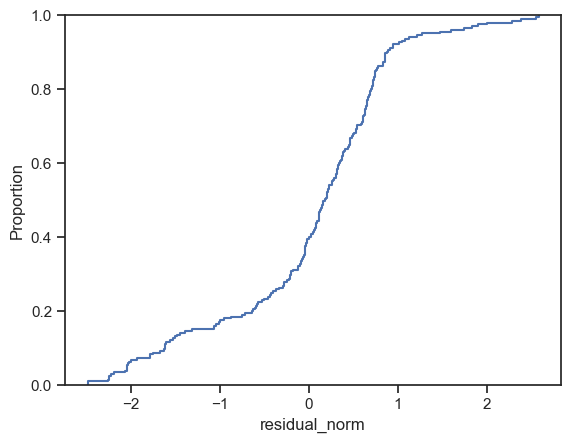

In [263]:
# Compute regression residual for each gene

df = pair_df

lr = LinearRegression()
lr.fit(np.array([[v] for v in x]), np.array(y))

yp = lr.predict(np.array([[v] for v in df.ko_frac]))
df['pred'] = yp

res = y - yp
df['residual'] = res

res = (res - res.mean()) / res.std()
df['residual_norm'] = res

sns.ecdfplot(df.residual_norm)

res_df = df
res_df

In [264]:
df = pair_df

df1 = df.loc[:, ['gene_1', 'residual_norm']]
df1['gene'] = df1.gene_1
df1['order'] = 1

df2 = df.loc[:, ['gene_2', 'residual_norm']]
df2['gene'] = df2.gene_2
df2['order'] = 2

df = pd.concat([df1, df2]).drop(['gene_1', 'gene_2'], axis=1).reset_index(drop=True)
df

residual_norm      gene  order
0        -1.782074      aceE      1
1        -1.752598      aceE      1
2        -2.487208      aceE      1
3        -2.051306      aceE      1
4        -1.631949      aceE      1
..             ...       ...    ...
405      -0.017599      aceA      2
406       0.337644        ME      2
407       0.063818  ppc_pckA      2
408       0.609684       Tal      2
409       0.403070       Pyk      2

[410 rows x 3 columns]

/var/folders/0z/0wtrv7xn7yq6df17wtbwn69c0000gn/T/ipykernel_66320/1689302271.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['+'.join(ko_map[x.get_text()]) for x in ax.get_yticklabels()])


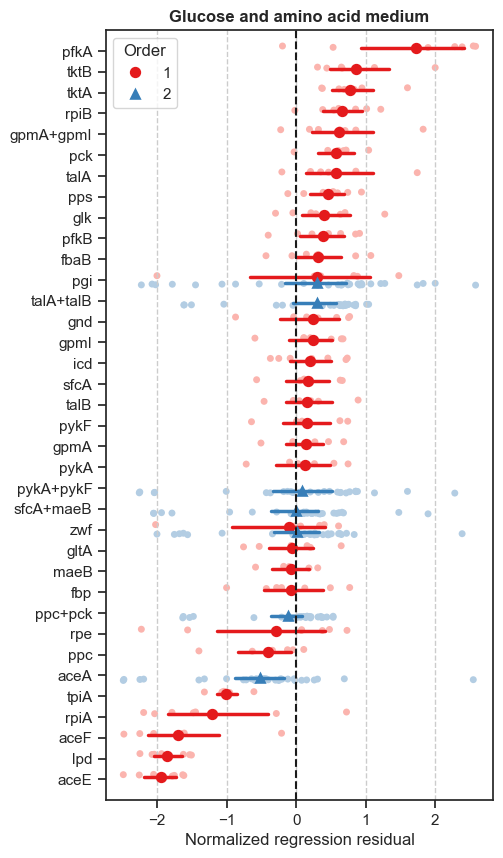

In [105]:
f = plt.figure()

order = list(df.groupby('gene').residual_norm.mean().sort_values(ascending=False).index)

ax = sns.pointplot(y='gene', x='residual_norm', hue='order', data=df, linestyle='none', order=order, palette='Set1', markers=['o', '^'], dodge=0.25, lw=2.5)
ax = sns.stripplot(y='gene', x='residual_norm', hue='order', data=df, order=order, palette='Pastel1', dodge=0.25, zorder=0)
# ax = sns.pointplot(y='gene_2', x='residual_norm', data=df1, linestyle='none', order=order, ax=ax)
# ax = sns.boxplot(y='gene_1', x='residual', data=df1, order=order)
# ax = sns.stripplot(y='gene_1', x='residual', hue='gene_2', data=df1, order=order)

ylim = df.gene.nunique(), -1

plt.plot([0] * 2, ylim, c='k', ls='--')

plt.ylim(ylim)
plt.grid(True, ls='--', axis='x')

t = 'Minimal glucose' if medium == 'min_glc' else 'Glucose and amino acid'
plt.title(t + ' medium', weight='bold')
plt.xlabel('Normalized regression residual')
plt.ylabel('')

# ax.set_yticklabels([x.get_text().replace('_', '+') for x in ax.get_yticklabels()])
ax.set_yticklabels(['+'.join(ko_map[x.get_text()]) for x in ax.get_yticklabels()])
# ax.set_yticklabels([x.get_text() + ' (' + '+'.join(ko_map[x.get_text()]) + ')' for x in ax.get_yticklabels()])

h, l = ax.get_legend_handles_labels()
ax.legend(h[:2], l[:2], title='Order')

f.set_size_inches(5, 10)
f.savefig(join(results_dir, 'ko_residuals_' + medium + '.pdf'), bbox_inches='tight')

(PearsonRResult(statistic=-0.30614521893737207, pvalue=8.037318535962551e-06),
 SignificanceResult(statistic=-0.0580952817691961, pvalue=0.40800430131568877))

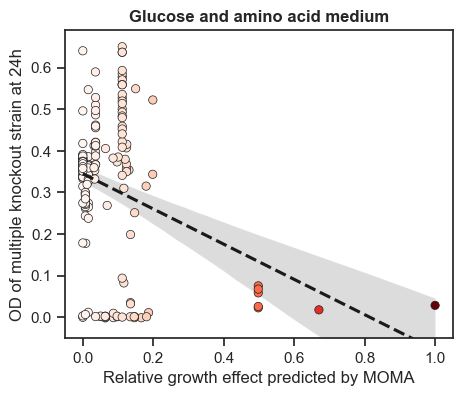

In [106]:
df = pair_df

# df = df[df.gene_2 == 'control']
# df = df[~df.gene_1.isin(['aceE', 'aceF', 'lpdA', 'rpiA'])]
# df = df[~df.gene_1.isin(['aceE', 'aceF', 'lpdA', 'tktA', 'tktB'])]
# df = df[~df.gene_1.isin(['aceE', 'aceF', 'lpdA', 'rpiA'])]
# df = df[~df.gene_1.isin(['pfkA'])]
# df = df[~df.gene_2.isin(['pgi'])]
# df = df[~df[['gene_1', 'gene_2']].isin(['zwf', 'pgi']).all(1)]
# df = df[~(df[['gene_1', 'gene_2']].isin(['zwf', 'pgi', 'rpe']).sum(1) == 2)]
# df = df[~df.gene_2.isin(['Tal'])]

x = df.ko_frac_fba
y = df.w_24h
hue = df.ko_frac_fba
# hue = None
# hue = df.gene_1_mops24
# hue = df.ko_frac < 0.43
# hue = df.gene_2
# hue = df.rgie
# hue = df.gene_1.isin(['pfkA'])
# hue = df.gene_1.isin(['tktA', 'tktB'])
# hue = df.gene_1.isin(['aceE', 'aceF', 'lpdA', 'rpiA'])
# hue += df[['gene_1', 'gene_2']].isin(['zwf', 'pgi', 'rpe']).sum(1) == 2
# hue = df.gene_1.isin(['aceE', 'aceF', 'lpdA']) | df[['gene_1', 'gene_2']].isin(['zwf', 'pgi']).all(1)
# hue = df.residual.abs() > 0.2

f = plt.figure()

ax = sns.regplot(x=x, y=y, scatter_kws=dict(color='w'), color='k', line_kws=dict(ls='--'))
ax = sns.scatterplot(x=x, y=y, hue=hue, palette='Reds', ec='k')
# palette='Reds'
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 0.69)

plt.title('Glucose and amino acid medium', weight='bold')
plt.xlabel('Relative growth effect predicted by MOMA')
plt.ylabel('OD of multiple knockout strain at 24h')

ax.legend().set_visible(False)

f.set_size_inches(5, 4)
f.savefig(join(results_dir, 'growth_ko_fba_' + medium + '.svg'), bbox_inches='tight')

pearsonr(x, y), spearmanr(x, y)

(PearsonRResult(statistic=0.1771931174043888, pvalue=0.011033042835036392),
 SignificanceResult(statistic=-0.057472074070805006, pvalue=0.41306030966135954))

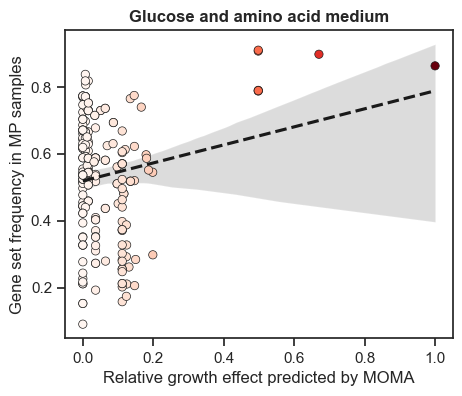

In [107]:
df = pair_df

# df = df[df.gene_2 == 'control']
# df = df[~df.gene_1.isin(['aceE', 'aceF', 'lpdA', 'rpiA'])]
# df = df[~df.gene_1.isin(['aceE', 'aceF', 'lpdA', 'tktA', 'tktB'])]
# df = df[~df.gene_1.isin(['aceE', 'aceF', 'lpdA', 'rpiA'])]
# df = df[~df.gene_1.isin(['pfkA'])]
# df = df[~df.gene_2.isin(['pgi'])]
# df = df[~df[['gene_1', 'gene_2']].isin(['zwf', 'pgi']).all(1)]
# df = df[~(df[['gene_1', 'gene_2']].isin(['zwf', 'pgi', 'rpe']).sum(1) == 2)]
# df = df[~df.gene_2.isin(['Tal'])]

x = df.ko_frac_fba
y = df.ko_frac
hue = df.ko_frac_fba
# hue = None
# hue = df.gene_1_mops24
# hue = df.ko_frac < 0.43
# hue = df.gene_2
# hue = df.rgie
# hue = df.gene_1.isin(['pfkA'])
# hue = df.gene_1.isin(['tktA', 'tktB'])
# hue = df.gene_1.isin(['aceE', 'aceF', 'lpdA', 'rpiA'])
# hue += df[['gene_1', 'gene_2']].isin(['zwf', 'pgi', 'rpe']).sum(1) == 2
# hue = df.gene_1.isin(['aceE', 'aceF', 'lpdA']) | df[['gene_1', 'gene_2']].isin(['zwf', 'pgi']).all(1)
# hue = df.residual.abs() > 0.2

f = plt.figure()

ax = sns.regplot(x=x, y=y, scatter_kws=dict(color='w'), color='k', line_kws=dict(ls='--'))
ax = sns.scatterplot(x=x, y=y, hue=hue, palette='Reds', ec='k')
# palette='Reds'
plt.xlim(-0.05, 1.05)

plt.title('Glucose and amino acid medium', weight='bold')
plt.xlabel('Relative growth effect predicted by MOMA')
plt.ylabel('Gene set frequency in MP samples')

ax.legend().set_visible(False)

f.set_size_inches(5, 4)
f.savefig(join(results_dir, 'ko_frequency_fba_' + medium + '.svg'), bbox_inches='tight')


pearsonr(x, y), spearmanr(x, y)

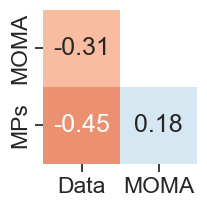

In [265]:
sns.set_theme(context='notebook', style='ticks', font_scale=1.5)

f = plt.figure()

df = pair_df
df = df[['w_24h', 'ko_frac_fba', 'ko_frac']].dropna()

df = df.corr() * np.tril(np.ones([df.shape[1]] * 2), k=-1)
df = df.loc[df.any(axis=1), df.any(axis=0)]
mask = 1 - np.tril(np.ones([df.shape[1]] * 2))

ax = sns.heatmap(df, annot=True, cmap='RdBu', center=0, mask=mask, cbar=False, square=True, vmax=1, vmin=-1)

# labels = ['Data', 'FBA',  'MPs']
# ax.set_xticklabels(labels)
# ax.set_yticklabels(labels)

ax.set_xticklabels(['Data',  'MOMA'])
ax.set_yticklabels(['MOMA',  'MPs'])

f.set_size_inches(2, 2)
f.savefig(join(results_dir, 'gene_frequency_corr_glc_aa.svg'), bbox_inches='tight')

In [278]:
# Write gene set frequency supplementary table
df = pair_df.iloc[:, [19, 21]]
df.index = [', '.join(sorted(set().union(*ko_pair))) for ko_pair in ko_pairs]
df = df.reset_index()
df.columns = ['ids', 'frequency_mp', 'frequency_moma']
df['names'] = [', '.join(sorted([model.genes.get_by_id(x).name for x in ids.split(', ')])) for ids in df.ids]
df = df[['ids', 'names', 'frequency_mp', 'frequency_moma']]
df.to_excel(join(results_dir, 'gene_set_frequency.xlsx'), index=False)

In [109]:
# Find isozymes
isozymes = set()
for x in ccm:
    r = model.reactions.get_by_id(x)
    gpr = r.gene_reaction_rule
    if ' or ' in gpr and not ' and ' in gpr:
        print()
        print(x)
        print(r.gpr)
        genes = frozenset(re.findall('b\\d{4}', gpr))
        if len(genes) < 2:
            continue
        reactions = set(frozenset(model.genes.get_by_id(b).reactions) for b in genes)
        if len(reactions) == 1:
            isozymes.add(genes)
isozymes


FORt2pp
b0904 or b2492

PGMT
b2690 or b0688

TKT2
b2935 or b2465

ALCD2x
b1478 or b1241 or b0356

ACONTa
b0118 or b1276

FBA
b2097 or b1773 or b2925

GLYCtpp
b3927 or s0001

ACALD
b0351 or b1241

MALS
b4014 or b2976

SUCCt2_3pp
b4123 or b4138

CAT
b1732 or b3942

GLCP
b3428 or b3417

SPODM
b3908 or b1656

PPA
b2744 or b4226 or b2502

PFK
b3916 or b1723

RPE
b4301 or b3386

HCO3E
b0126 or b0339

PTAr
b2297 or b2458

L_LACt2rpp
b3603 or b2975

PGM
b3612 or b4395 or b0755

FBP
b3925 or b4232 or b2930

FUM
b1612 or b4122 or b1611

ACONTb
b0118 or b1276

XYLK
b0063 or b3564

TALA
b2464 or b0008

F6PA
b0825 or b3946

PYK
b1854 or b1676

GLCP2
b3417 or b3428

MALt2_3pp
b4123 or b4138

D_LACt2pp
b3603 or b2975

GLCDpp
b0124 or b0837

TKT1
b2935 or b2465

ACKr
b3115 or b2296 or b1849

FORtppi
b0904 or b2492

LDH_D
b2133 or b1380

PPA2
b2502 or b2744

FUMt2_3pp
b4138 or b4123 or b0621

RPI
b2914 or b4090


{frozenset({'b1732', 'b3942'}),
 frozenset({'b0904', 'b2492'}),
 frozenset({'b0825', 'b3946'}),
 frozenset({'b2975', 'b3603'}),
 frozenset({'b1676', 'b1854'}),
 frozenset({'b0124', 'b0837'}),
 frozenset({'b1656', 'b3908'}),
 frozenset({'b0688', 'b2690'}),
 frozenset({'b2976', 'b4014'}),
 frozenset({'b0755', 'b3612', 'b4395'}),
 frozenset({'b0008', 'b2464'}),
 frozenset({'b2930', 'b3925', 'b4232'}),
 frozenset({'b3386', 'b4301'}),
 frozenset({'b0126', 'b0339'}),
 frozenset({'b2465', 'b2935'})}